Visualizing autoencoded books on various themes in 2D space/

In [1]:
from htrc import workset
from htrc_features import FeatureReader, utils
import glob
import numpy as np
import pandas as pd
from ef_utils import *

In [2]:
trim_head = 200
token_ref = load_tokenref('eng-vocab-1.txt.bz2', trim_head=trim_head)
token_dict = tokenref2dict(token_ref)
idf = np.load('idf-1.npy')[trim_head:]

## Convert worksets into sparse vectors

In [28]:
knitids = workset.load_hathitrust_collection('https://babel.hathitrust.org/cgi/mb?a=listis&c=1174943610')
sewids = workset.load_hathitrust_collection('https://babel.hathitrust.org/cgi/mb?a=listis&c=973680817')
cookids = workset.load_hathitrust_collection('https://babel.hathitrust.org/cgi/mb?a=listis&c=272315082')
sportsids = workset.load_hathitrust_collection('https://babel.hathitrust.org/cgi/mb?a=listis&c=1219958938')
comedyids = workset.load_hathitrust_collection('https://babel.hathitrust.org/cgi/mb?a=listis&c=1472815978')

for ids, outdir in [(sportsids, 'sports'), (comedyids, 'comedy')]:
    try:
        utils.download_file(ids, outdir='data/ef-files/%s' % outdir)
    except:
        pass

In [29]:
for group in ['cooking', 'knitting', 'sewing', 'sports', 'comedy']:
    print(group.upper())
    paths = glob.glob('data/ef-files/%s/*' % group)
    fr = FeatureReader(paths)
    
    all_arrs = []
    all_ids = []
    all_titles = []
    i = 0
    for vol in fr.volumes():
        try:
            volids, arr = vol2vec(vol, token_dict, len(token_ref), idf=idf, bypage=False)
        except:
            continue
        all_arrs.append(arr)
        all_ids += volids
        all_titles += [vol.title] * len(volids)
        i += 1
        if i % 10 == 0:
            print(i, end=',')

    stacked_arrs = np.vstack(all_arrs)
    np.savez_compressed('data/ef-files/%s-counts' % group, counts=stacked_arrs, ids=all_ids, titles=all_titles)
    print()

COMEDY
10,20,30,40,50,60,70,80,90,


## Generate Latent Codes for the Books

In [ ]:
import numpy as np
import scipy.stats
import pandas as pd
from vae import create_vae, restore_model
import tensorflow as tf
from vaeArgs import *

In [5]:
# Avoid GPU for memory issues (so I can do analysis while GPU is training elsewhere)
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True,
                                                   device_count={'GPU': 0}))

In [4]:
sess.close()

In [6]:
args, vae = restore_model('models/L0.0000100-D200000_1200_800_200-b256-N120000-E1000-l1000.0-a1.0-v202498-kMMD-idf-keras-full.h5')
encoder = vae.get_layer('encoder')

## Export Coordinates and metadata

For review in https://projector.tensorflow.org/

In [7]:
all_coords = []
ids = []
labels = []
titles = []

for group in ['sewing', 'knitting', 'cooking', 'sports', 'comedy']:
    data = np.load('data/ef-files/%s-counts.npz' % group)
    insize = args.dims[0]
    coords = encoder.predict(data['counts'][:, :insize])
    if type(coords) == list:
        coords = coords[0]
    all_coords.append(coords)
    ids += list(data['ids'])
    titles += list(data['titles'])
    labels += [group] * len(data['ids'])

all_coords = np.vstack(all_coords)
all_coords.shape, len(titles), len(labels), len(ids)

meta = pd.DataFrame(dict(titles=titles, labels=labels, ids=ids))
meta.to_csv('export/meta.csv', sep='\t', index=False)
np.savetxt("export/data.csv", all_coords, delimiter="\t")

## Visualize two dimensional codes

In [7]:
%matplotlib inline
import seaborn as sns

In [ ]:
all_df = []
for group in ['sewing', 'knitting', 'cooking', 'sports', 'comedy']:
    data = np.load('data/ef-files/%s-counts.npz' % group)
    insize = args.dims[0]
    coords = encoder.predict(data['counts'][:, :insize])
    if type(coords) == list:
        coords = coords[0]
    df = pd.DataFrame(coords)
    
    df['htid'] = data['ids']
    df['group'] = group
    all_df.append(df)
df = pd.concat(all_df)
df.sample(5)

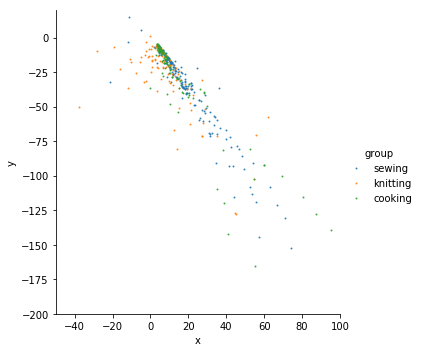

In [19]:
# MMD
sns.lmplot(x='x', y='y', data=df, hue='group', scatter_kws={"s": 1}, fit_reg=False).set(xlim=(-50, 100), ylim=(-200, 20))

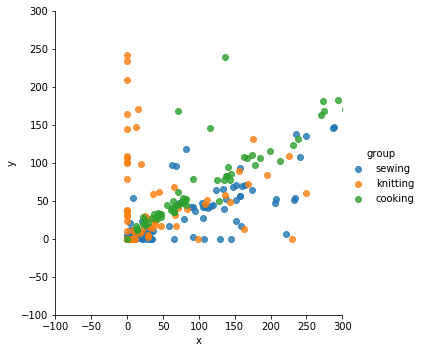

In [12]:
# None
sns.lmplot(x='x', y='y', data=df, hue='group', fit_reg=False, scatter_kws={"s": 1}).set(xlim=(-100, 300), ylim=(-100, 300))

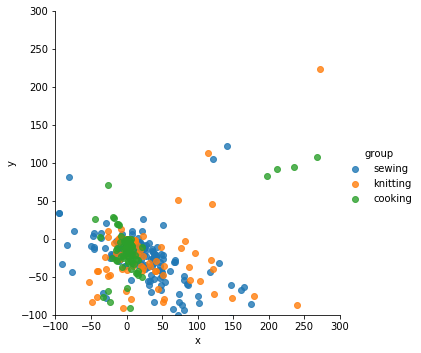

In [9]:
# ELBO
sns.lmplot(x='x', y='y', data=df, hue='group', fit_reg=False, scatter_kws={"s": 1}).set(xlim=(-100, 300), ylim=(-100, 300))